In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import UnivariateSpline
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append("../")

### Import Desired Tires

In [33]:
all_tires = {
    "Hoosier_18x6.0-10_LCO_6_cornering":{"long":None, "lat":None},
    "Hoosier_18x6.0-10_LCO_7_cornering":{"long":None, "lat":None},
    "Hoosier_18x6.0-10_R20_6_cornering":{"long":None, "lat":None},
    "Hoosier_18x6.0-10_R20_7_cornering":{"long":None, "lat":None},
}

### Filter Data

In [34]:
camber = 0 # default camber
pressure = 12 * 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
slip_angle = 0
tire_scaling = 2/3

tire_dict = all_tires.items()

for name, tire in tire_dict:
    try:
        df = pd.read_csv(f"../processing/results/{name}.csv")
        tire["long"] = df[(df["pressure"] == pressure) & (df["velocity"] == velocity) & (df["camber"] == camber) & (df["slip"] == slip_angle)]
    except:
        print("Error getting long data for {0}".format(name))

    try:
        df = pd.read_csv(f"../processing/results/{name}.csv")
        tire["lat"] = df[((df["velocity"] == velocity) & (df["pressure"] == pressure) & (df["camber"] == camber))]
    except:
        print("Error getting lateral data for {0}".format(name))

### Calculate Lateral Friction Coefficient

In [35]:
peak_mu_lst = []
normal_load_lst = []
tire_name = []

normal_loads = sorted(np.array(tire["lat"]["load"].unique()))

for name, tire in all_tires.items():
    current_peak_mu = []
    current_normal_load = []
    for load in normal_loads:
        temp = tire["lat"][tire["lat"]["load"] == load]
        peak_mu = max(temp["FY"]) * 2/3 / abs(load)

        current_peak_mu.append(peak_mu)
        current_normal_load.append(load)

    normal_load_lst.append(current_normal_load)
    peak_mu_lst.append(current_peak_mu)
    tire_name.append(name[10:])

### Check mu visually to filter out points

[222.4110244696609, 444.8220489393218, 667.2330734089827, 889.6440978786436, 1112.0551223483046]
[1.9296405578666669, 1.7833648352000002, 1.7010447751555557, 1.7378185318000001, 1.5748260118933333]


Text(0, 0.5, 'Lateral Friction Coefficient')

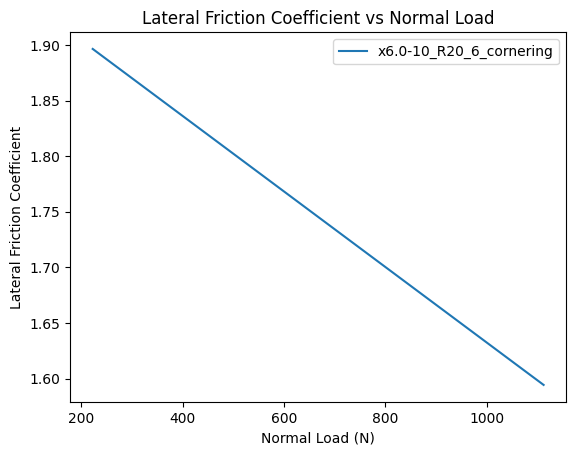

In [36]:
tire_names = tire_name[::-1]

for i in range(len(peak_mu_lst)):
    reversed_mu = peak_mu_lst[i][::-1]
    adjusted_FZ = sorted(-1 * np.array(normal_load_lst[i]))
    plot = UnivariateSpline(adjusted_FZ, reversed_mu, k = 1)
    x_vals = np.linspace(min(adjusted_FZ), max(adjusted_FZ), 100)
    y_vals = plot(x_vals)
    plt.plot(x_vals, y_vals)

    print(adjusted_FZ)
    print(reversed_mu)

    # plt.scatter(adjusted_FZ, reversed_mu)

plt.legend(tire_names)
plt.title("Lateral Friction Coefficient vs Normal Load")
plt.xlabel("Normal Load (N)")
plt.ylabel("Lateral Friction Coefficient")

### Manual Mu Filtering for 16" Tires

In [37]:
name_1 = "cornering_Hoosier_18x6.0-10_LCO_6"
FZ_1 = [222.4110244696609, 444.8220489393218, 667.2330734089827, 889.6440978786436, 1112.0551223483046]
Mu_1 = [2.095699472533333, 1.8105517369333335, 1.7402015072000003, 1.6534402204666667, 1.501274502]

name_2 = "cornering_Hoosier_18x6.0-10_LCO_7"
FZ_2 = [222.4110244696609, 444.8220489393218, 667.2330734089827, 889.6440978786436, 1112.0551223483046]
Mu_2 = [1.9922273834666666, 1.7673434471333334, 1.7063103015111112, 1.635972561166667, 1.5540836348266667]

name_3 = "cornering_Hoosier_18x6.0-10_R20_6"
FZ_3 = [222.4110244696609, 444.8220489393218, 667.2330734089827, 889.6440978786436, 1112.0551223483046]
Mu_3 = [1.9296405578666669, 1.7833648352000002, 1.7010447751555557, 1.7378185318000001, 1.5748260118933333]

name_4 = "cornering_Hoosier_18x6.0-10_R20_7"
FZ_4 = [222.4110244696609, 444.8220489393218, 667.2330734089827, 889.6440978786436, 1112.0551223483046]
Mu_4 = [1.9848836228000002, 1.8248495893333332, 1.7538199368444445, 1.6825679732333332, 1.6360459987733331]

tire_names = [name_1, name_2, name_3, name_4]
FZ_lst = [FZ_1, FZ_2, FZ_3, FZ_4]
Mu_lst = [Mu_1, Mu_2, Mu_3, Mu_4]

### Calculate Slope Magnitudes of Mu vs FZ

In [38]:
modified_FZ_lst = [[-1 * x for x in y[::-1]] for y in FZ_lst]
modified_mu_lst = [x[::-1] for x in Mu_lst]

slope_magnitudes = []

for i in range(len(tire_names)):
    # plt.scatter(modified_FZ_lst[i], modified_mu_lst[i])
    plot = UnivariateSpline(modified_FZ_lst[i], modified_mu_lst[i], k = 1)
    x_vals = np.linspace(min(modified_FZ_lst[1]), max(modified_FZ_lst[1]), 100)
    y_vals = plot(x_vals)
    slope_magnitudes.append(abs((plot(600) - plot(400)) / (600 - 400)))
    # plt.plot(x_vals, y_vals)

# plt.legend(tire_names)
# plt.title("Lateral Friction Coefficient vs Normal Load")
# plt.xlabel("Normal Load (N)")
# plt.ylabel("Lateral Friction Coefficient")

### Save Tire Names and Mu vs FZ Slope Magnitudes to .csv

In [39]:
adjusted_magnitudes = [x * 1000 for x in slope_magnitudes]

output_df = pd.DataFrame()
output_df["Tire"] = tire_names
output_df["abs(slope) * 1000"] = adjusted_magnitudes

output_df.to_csv("18_inch_load_sens.csv")


### Calculate Cornering Stiffnesses

In [40]:
load_lst = []
cornering_stiffness_lst = []
tire_name = []

for name, tire in all_tires.items():
    current_load = []
    current_cornering_stiffness = []
    for load in normal_loads:
        temp = tire["lat"][tire["lat"]["load"] == load][(tire["lat"]["SA"] < 1) & (tire["lat"]["SA"] > -1)]
        cornering_stiffness = (max(temp["FY"]) - min(temp["FY"])) / 2

        current_load.append(load)
        current_cornering_stiffness.append(cornering_stiffness)

    load_lst.append(current_load)
    cornering_stiffness_lst.append(current_cornering_stiffness)
    tire_name.append(name[:23])


/tmp/ipykernel_47999/47000368.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = tire["lat"][tire["lat"]["load"] == load][(tire["lat"]["SA"] < 1) & (tire["lat"]["SA"] > -1)]


### Plot Cornering Stiffness

Text(0, 0.5, 'Cornering Stiffness (N/deg)')

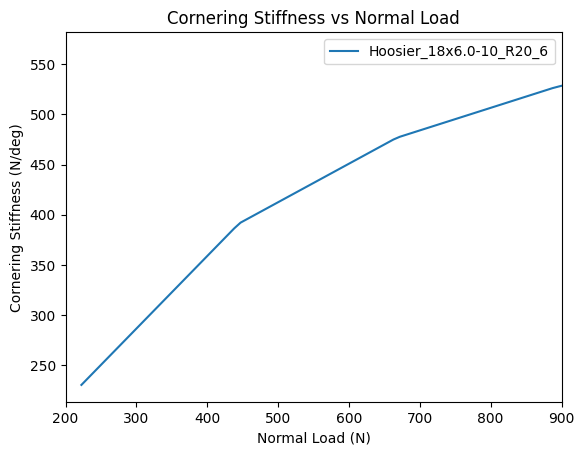

In [41]:
for i in range(len(cornering_stiffness_lst)):
    adjusted_FZ = -1 * np.array(load_lst[i])
    # plt.scatter(adjusted_FZ, cornering_stiffness_lst[i])

    plot = UnivariateSpline(adjusted_FZ[::-1], cornering_stiffness_lst[i][::-1], k = 1)
    x_vals = np.linspace(min(adjusted_FZ), max(adjusted_FZ), 100)
    y_vals = plot(x_vals)
    
    plt.plot(x_vals, y_vals)

plt.xlim(200, 900)
    
plt.legend(tire_name)
plt.title("Cornering Stiffness vs Normal Load")
plt.xlabel("Normal Load (N)")
plt.ylabel("Cornering Stiffness (N/deg)")